In [75]:
import numpy as np 
import pandas as pd
import scipy.stats as st
import tqdm.notebook as tq
import matplotlib.pyplot as plt
from utils.utils import *
from utils.models import *

# Generate synthetic data

In [141]:
def generate_data(num_samples, num_features, institution_range=(1, 1), seed=None):
    """
    Generates synthetic data for modeling.

    Parameters:
    - num_samples: Number of samples to generate.
    - num_features: Number of feature columns to generate.
    - institution_range: Tuple indicating the range of institution ids to generate. 
      For single value institutions, use the same value for both elements.
    - seed: Random seed for reproducibility.

    Returns:
    A pandas DataFrame with generated data.
    """
    if seed is not None:
        np.random.seed(seed)  # For reproducibility

    # Generating 'gold' scores between 0 and 1
    risk = np.random.rand(num_samples)

    # Generating 'risk' based on 'gold' scores
    gold_scores = (np.random.rand(num_samples) < risk) * 1
    # Add some noise by randomly flipping some labels
    noise_rate = 0.25
    indices_to_flip = np.random.choice(np.arange(num_samples), size=int(noise_rate * num_samples), replace=False)
    gold_scores[indices_to_flip] = 1 - gold_scores[indices_to_flip]

    # Generating additional feature columns
    features = {f'feature_{i+1}': np.random.rand(num_samples) for i in range(num_features)}

    # Assembling the DataFrame
    data = {
        'risk': risk,  # Convert boolean to int (0 or 1)
        'gold': gold_scores,
        **features,
    }

    # If the institution_range has distinct start and end, generate random integers within the range
    if institution_range[0] != institution_range[1]:
        data['institution'] = np.random.randint(institution_range[0], institution_range[1]+1, num_samples).astype(str)
    else:
        data['institution'] = (np.ones(num_samples, dtype=int) * institution_range[0]).astype(str)

    df = pd.DataFrame(data)
    return df

# Generating source and target DataFrames
df_source = generate_data(10000, 5, institution_range=(2, 30), seed=0)
df_target = generate_data(100, 5, institution_range=(1, 1), seed=None)  # Seed is None for truly random generation in the target data

# Estimating the optimal threshold

Here, we illustrate how to use our code estimate thresholds with our different baselines and our method. If the available target data is not labeled, the flag "include_target" should be turned to false in the transferable threshold's pipeline function.  

The pipeline functions return a dictionary containing multiple results: 
- Tau: the estimated threshold
- Alpha_emp: the achieved PPV with that threshold on the available target data. 
- Additional metrics: coverage, npv, total number of positives in the target, size of the target

In [142]:
# Initialize our method

transfer = TransferableThreshold()

# Initiliaze baselines

platt = PlattEstimator()
regression = RegressionEstimator()

# Target PPV

alpha = 0.7

In [143]:
# Estimate the optimal threshold on our dataset

estimations = {
    
        'transferable_threshold': transfer.pipeline(df_source, df_target, "institution", "risk", 
                                                    "gold", alpha=alpha)["tau"],
    
        'importance_sampling': transfer.pipeline(df_source, df_target, "institution", "risk", "gold",
                                                 combin_factor=False, include_target=False, alpha=alpha)["tau"],
    
        'platt_scaling': platt.pipeline(df_target, "risk", "gold", alpha=alpha)["tau"],
    
        'linear_regression': regression.pipeline(df_source, df_target, "institution", "risk", "gold",
                                                 alpha=alpha, compute_regs=True)["tau"],
    
        'empirical_estimation': simple_estimator(df_target, "risk", "gold")["tau"]
    
    }

pd.DataFrame([{'method': method, 'Proposed threshold': tau} for method, tau in estimations.items()])

,method,Proposed threshold
0,transferable_threshold,0.717185
1,importance_sampling,0.725594
2,platt_scaling,0.511827
3,linear_regression,0.682399
4,empirical_estimation,0.014045


# Experimental mode

For experiment purposes, you might use a target dataset for which you have large amounts of data.  
In that context, you would extract a small subset of the data to simulate a real clinical scenario, but you can evaluate the performance of your estimated thresholds on the full held-out dataset. The flag frac_sample (percentage of the full dataset to use for the threshold estimation) will allow you to do that within the different methods. The value "alpha_emp" returned by the pipeline function will be evaluated on the full held-out dataset.

We illustrate it by reproducing one of the paper's experiment on our synthetic data. This is simply an illustration of the code's functionalities. The results of this section are not indicative of anything as we are applying the methods on randomly generated datasets and risk scores.

In [150]:
df_target = generate_data(5000, 5, institution_range=(1, 1), seed=None)
num_experiments = 25
n = 150 
len_target = len(df_target)

# Initialize empty DataFrames to store the results

results_platt = pd.DataFrame()
results_reg = pd.DataFrame()
results_transfer = pd.DataFrame()
results_empirical = pd.DataFrame()

alpha_values = np.linspace(0.5, 0.8, 7)

# Single loop to iterate over experiments and alpha values
# One experiment corresponds to using one random subsample of size n of the total available target dataset
for a in tq.tqdm(range(num_experiments)):
    
    # Call the pipeline functions once for each experiment
    platt_results = [platt.pipeline(df_target, "risk", "gold", alpha=i, frac_sample=n/len_target, random_state=a) 
                        for i in alpha_values]
    
    reg_results = [regression.pipeline(df_source, df_target, "institution", "risk", "gold", alpha=i, 
                                      frac_sample=n/len_target, random_state=a, compute_regs = True) 
                        for i in alpha_values]
    
    empirical_results = [simple_estimator(df_target, "risk", "gold", alpha=i, 
                                          frac_sample=n/len_target, random_state=a) 
                        for i in alpha_values]
    
    transfer_results = [transfer.pipeline(df_source, df_target, "institution", "risk", "gold",
                                 alpha=i, sampling_direction='down', frac_sample=n/len_target, random_state=a, 
                                 normalize=False, combin_factor = True, include_target = True)  
                        for i in alpha_values]
    

    # Calculate results and coverage for each alpha value
    #results[a] = [np.maximum(i - result["alpha_emp"], 0) for i,result in zip(alpha_values, pipeline_results)]
    results_platt[a] = [np.abs(i - result["alpha_emp"]) for i,result in zip(alpha_values, platt_results)]
    results_reg[a] = [np.abs(i - result["alpha_emp"]) for i,result in zip(alpha_values, reg_results)]
    results_empirical[a] = [np.abs(i - result["alpha_emp"]) for i,result in zip(alpha_values, empirical_results)]
    results_transfer[a] = [np.abs(i - result["alpha_emp"]) for i,result in zip(alpha_values, transfer_results)]
    
# Confidence intervals

ci_platt = np.array([st.t.interval(0.9, len(np.transpose(results_platt)[a])-1, 
                                   loc=np.nanmean(np.transpose(results_platt)[a]), scale=st.sem(np.transpose(results_platt)[a], nan_policy='omit')) for a in range(len(alpha_values))])
ci_reg = np.array([st.t.interval(0.9, len(np.transpose(results_reg)[a])-1, 
                                   loc=np.nanmean(np.transpose(results_reg)[a]), scale=st.sem(np.transpose(results_reg)[a], nan_policy='omit')) for a in range(len(alpha_values))])
ci_empirical = np.array([st.t.interval(0.9, len(np.transpose(results_empirical)[a])-1, 
                                   loc=np.nanmean(np.transpose(results_empirical)[a]), scale=st.sem(np.transpose(results_empirical)[a], nan_policy='omit')) for a in range(len(alpha_values))])
ci_transfer = np.array([st.t.interval(0.9, len(np.transpose(results_transfer)[a])-1, 
                                   loc=np.nanmean(np.transpose(results_transfer)[a]), scale=st.sem(np.transpose(results_transfer)[a], nan_policy='omit')) for a in range(len(alpha_values))])

  0%|          | 0/25 [00:00<?, ?it/s]

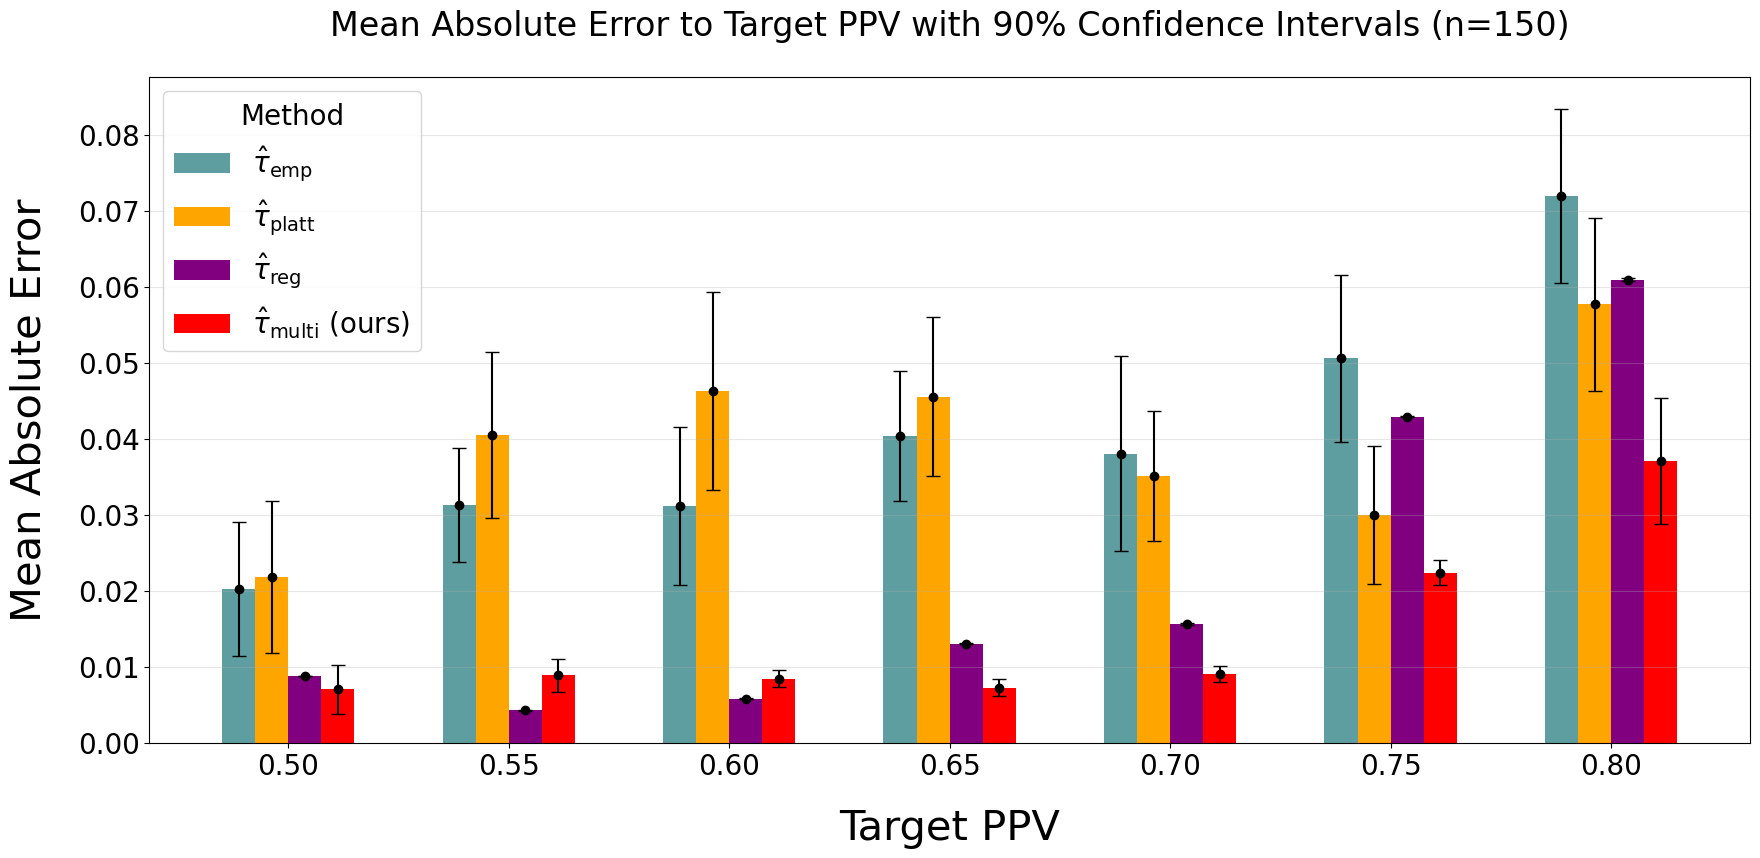

In [151]:
# Plot the results

methods = [r'$\hat{\tau}_\mathrm{emp}$', r'$\hat{\tau}_\mathrm{platt}$', 
           r'$\hat{\tau}_\mathrm{reg}$', r'$\hat{\tau}_\mathrm{multi}$ (ours)']
alphas = alpha_values
average_errors = {
    r'$\hat{\tau}_\mathrm{emp}$': results_empirical.mean(axis = 1),
    r'$\hat{\tau}_\mathrm{multi}$ (ours)': results_transfer.mean(axis = 1),
    r'$\hat{\tau}_\mathrm{platt}$': results_platt.mean(axis = 1),
    r'$\hat{\tau}_\mathrm{reg}$': results_reg.mean(axis = 1),
}
confidence_intervals = {
    r'$\hat{\tau}_\mathrm{emp}$': ci_empirical,
    r'$\hat{\tau}_\mathrm{multi}$ (ours)': ci_transfer,
    r'$\hat{\tau}_\mathrm{platt}$': ci_platt,
    r'$\hat{\tau}_\mathrm{reg}$': ci_reg,
}

# Plotting
plt.figure(figsize=(18, 9))
plt.rcParams.update({'font.size': 20})
#plt.style.use('classic')
colors = ['cadetblue', 'orange', 'purple', 'red']

for i, method in enumerate(methods):
    average_error = average_errors[method]
    lower_bound = [ci[0] for ci in confidence_intervals[method]]
    upper_bound = [ci[1] for ci in confidence_intervals[method]]

    # Calculate the error bars (yerr)
    error_lower = np.array(average_error) - np.array(lower_bound)
    error_upper = np.array(upper_bound) - np.array(average_error)

    # Plot the bar chart for each method with thicker bars (linewidth=2)
    plt.bar(np.arange(len(alphas)) + i*0.15, average_error, width=0.15, label=method, linewidth=2, color = colors[i])
    plt.errorbar(np.arange(len(alphas)) + i*0.15, average_error, yerr=[error_lower, error_upper], fmt='o', capsize=5, color='black')

# Format the alpha values in the legend to two decimal places
formatted_alphas = ['{:.2f}'.format(alpha) for alpha in alphas]
plt.xticks(np.arange(len(alphas)) + 0.15*(len(methods)/2 - 0.5), formatted_alphas)
plt.xlabel('Target PPV', labelpad = 20, fontsize = 30)
plt.ylabel('Mean Absolute Error', labelpad = 20, fontsize = 30)
plt.title('Mean Absolute Error to Target PPV with 90% Confidence Intervals (n=' + str(n) + ')', 
          y = 1.05, fontsize = 24)
plt.legend(title='Method', bbox_to_anchor=(0.0, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()# Define x values